## **Code**

In [1]:
import torch
import torch.distributions as ds
from models import PolyGaussianRegressionModel as PGRM
import matplotlib.pyplot as plt
from util import add_output_noise, bayes_factor, same_poly_model_family
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({
        'font.family' : 'Times',
        'font.size' : 9,
        'axes.titlesize' : 9,
        'axes.labelsize' : 8,
        'xtick.labelsize' : 8,
        'ytick.labelsize' : 8,
        'legend.fontsize': 8,
        'lines.markersize': 2,
        'legend.shadow' : False,
        'legend.framealpha' : 1,
        'legend.fancybox' : True,
        'legend.edgecolor' : 'black',
        'patch.linewidth' : 0.75,
        'legend.handlelength' : 1,
        'text.usetex' : True,
        'text.latex.preamble' : r'''
    \usepackage{amsmath}
    \usepackage{amssymb}
    \usepackage{times}
    \usepackage{bm}
    \usepackage{times}
''',
    }) 

In [3]:
def compare_models(m1, m2, trials, n):
  successes = 0
  lls = torch.zeros(2, trials)

  for i in range(trials):
    x_train = ds.Uniform(-1.0, 1.0).sample((n,))

    w = m1.sample_model_weights()
    y_train = add_output_noise(m1.predict(x_train, w))
    
    log_bf, ll1, ll2 = bayes_factor(m1, m2, x_train, y_train)

    if log_bf >= 0:
      successes += 1
    
    lls[0,i] = ll1
    lls[1,i] = ll2

  if same_poly_model_family(m1, m2):
    sr = 0.5
  else:
    sr = successes / trials

  return sr, lls

In [4]:
def get_metrics(m1_terms, m2_terms, n_terms, mu=0, var=1, trials=200, n=100):
  success_map = torch.zeros(n_terms, n_terms)
  log_likelihoods = torch.zeros(n_terms, n_terms, 2, trials)

  with tqdm(total=n_terms*n_terms) as pbar:
    for d1 in range(n_terms):
      for d2 in range(n_terms):
        pbar.set_description(f'd1={d1}, d2={d2}')

        m1 = PGRM(mu, var, m1_terms, d1)
        m2 = PGRM(mu, var, m2_terms, d2)

        sr, lls = compare_models(m1, m2, trials, n)

        success_map[d1,d2] = sr
        log_likelihoods[d1,d2] = lls
        
        pbar.update(1)

    return success_map, log_likelihoods


In [5]:
def plot_log_likelihoods(lls, title='', ds=-1, out=None):
  n_terms = len(lls)
  if ds == -1:
    ds = range(n_terms)

  fig, axs = plt.subplots(len(ds), len(ds), figsize=(2*len(ds), 2*len(ds)))
  fig.subplots_adjust(top=0.9, wspace=0.3, hspace=0.7)
  fig.suptitle(f'Log likelihoods\n{title}')

  c1, c2, a = 'indigo', 'salmon', 0.6

  for i, d1 in enumerate(ds):
    for j, d2 in enumerate(ds):
      ax = axs[i,j]
      ax.set_yticks([])
      ll1, ll2 = lls[d1,d2]
      _, bins, _ = ax.hist(ll1.reshape(1, -1), color=c1, bins=40, label=fr'$d_1={d1}$ (True)')
      ax.hist(ll2.reshape(1, -1), alpha=a, color=c2, bins=bins, label=fr'$d_2={d2}$ (Hyp.)')
      ax.axvline(ll1.mean(), alpha=a, c=c1, lw=0.1)
      ax.axvline(ll2.mean(), alpha=a, c=c2, lw=0.1)
      ax.set_title(f'$d_1 = {d1}, \; d_2 = {d2}$')
      ax.set_xlabel('Marginal log likelihood', labelpad=2)
      ax.set_ylabel('')

  if out:
    plt.savefig(f'output/{out}.pdf', bbox_inches='tight')
  else:
    plt.show()

In [6]:
def plot_log_likelihood(lls, d1, d2, out=None):
  _, ax = plt.subplots(1, 1, figsize=(4, 2))
  # ax.set_yticks([])
  ll1, ll2 = lls[d1,d2]
  c1, c2, a = 'indigo', 'salmon', 0.6
  _, bins, _ = ax.hist(ll1.reshape(1, -1), color=c1, bins=40, label=fr'$d_1={d1}$ (True)')
  ax.hist(ll2.reshape(1, -1), alpha=a, color=c2, bins=bins, label=fr'$d_2={d2}$ (Hyp.)')
  ax.axvline(ll1.mean(), alpha=a, c=c1, lw=0.1)
  ax.axvline(ll2.mean(), alpha=a, c=c2, lw=0.1)
  ax.set_xlabel('Marginal log likelihood', labelpad=2)
  ax.set_ylabel('Number of trials', labelpad=2)
  ax.legend()
  if out:
    plt.savefig(f'output/{out}.pdf', bbox_inches='tight')
  else:
    plt.show()    

In [7]:
def plot_heatmap(sm, title='', out=None):
  fig, ax = plt.subplots(1, 1, figsize=(4, 2))
  heat_map = ax.imshow(sm, cmap='magma', interpolation='none', origin='lower')
  fig.colorbar(heat_map)
  if title:
    ax.set_title(title)
  ax.set_ylabel(fr'$d_1$ (True)')
  ax.set_xlabel(fr'$d_2$ (Hyp.)')
  if out:
    plt.savefig(f'output/{out}.pdf', bbox_inches='tight')
  else:
    plt.show()

## **True: all, Hyp: all**

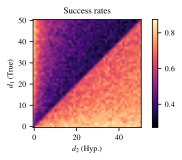

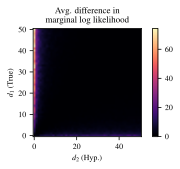

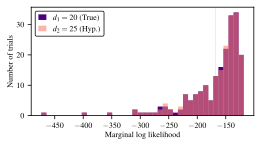

In [8]:
sm = torch.load('output/sm1.pt')
lls = torch.load('output/lls1.pt')
avg_lls = lls.mean(-1)
plot_heatmap(sm, title='Success rates')
plot_heatmap(avg_lls[:,:,0] - avg_lls[:,:,1], title='Avg. difference in\nmarginal log likelihood')
plot_log_likelihood(lls, d1=20, d2=25)

## **True: even, Hyp.: odd**

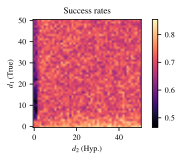

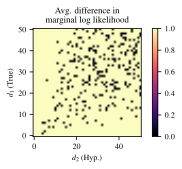

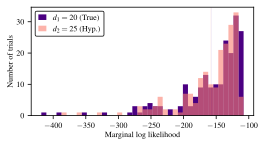

In [22]:
sm = torch.load('output/sm2.pt')
lls = torch.load('output/lls2.pt')
avg_lls = lls.mean(-1)
plot_heatmap(sm, title='Success rates')
plot_heatmap(avg_lls[:,:,0] > avg_lls[:,:,1], title='Avg. difference in\nmarginal log likelihood')
plot_log_likelihood(lls, d1=20, d2=25)

## **True: odd, Hyp.: even**

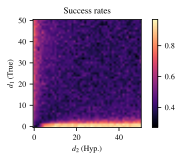

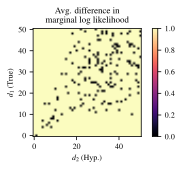

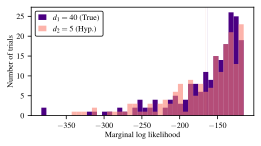

In [21]:
sm = torch.load('output/sm3.pt')
lls = torch.load('output/lls3.pt')
avg_lls = lls.mean(-1)
plot_heatmap(sm, title='Success rates')
plot_heatmap(avg_lls[:,:,0] > avg_lls[:,:,1], title='Avg Marginal log likelihood')
plot_log_likelihood(lls, d1=40, d2=5)

## **More plots**

In [ ]:
plot_heatmap(torch.load('output/sm1.pt'), title='(all vs. all)')
plot_heatmap(torch.load('output/sm2.pt'), title='(even vs. odd)')
plot_heatmap(torch.load('output/sm3.pt'), title='(odd vs. even)')

In [ ]:
ds = [0, 1, 2, 5, 10, 25, 50]
plot_log_likelihoods(torch.load('output/lls1.pt'), ds=ds, title='All vs. all')
plot_log_likelihoods(torch.load('output/lls2.pt'), ds=ds, title='(even vs. odd)')
plot_log_likelihoods(torch.load('output/lls3.pt'), ds=ds, title='(even vs. odd)')


## **Tests**

In [ ]:
m1 = PGRM(0, 1, 'all', 3)
plt.hist(m1.sample_model_weights(1000).T)
plt.show()

In [ ]:
w = torch.randn(10)
torch.special.exp2(w)

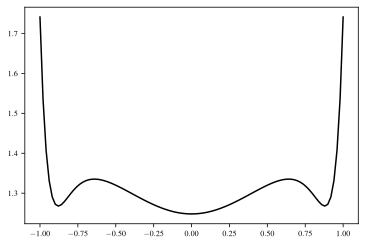

In [15]:
D = 10
m1 = PGRM(0, 1, 'even', D)
w = m1.sample_model_weights()
# ell = 1.5 ** torch.arange(D+1)
# w = w.reshape(-1) / ell
# print(w)
# x = torch.linspace(-5, 5, 100)
# _, ax = plt.subplots(1, 1)
# ax.plot(x, m1.predict(x, w), c='k')
x = torch.linspace(-1, 1, 100)
# ax.plot(x, m1.predict(x, w), c='tomato', linewidth=3)
_, ax = plt.subplots(1, 1)
ax.plot(x, m1.predict(x, w), c='k')
# ax.scatter(x, m1.predict(x, w), c='g')